In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber



# Modelo LSTM

## Carga de datos y tratamiento de datos

In [2]:
# Carga de datos
url ="https://raw.githubusercontent.com/adeulofeu/TFM/refs/heads/main/data/dataset_modelos.csv"
dataset_energia = pd.read_csv(url)

In [3]:
# Se crean las columnas de fecha separados por año, mes y día
dataset_energia['ano'] = pd.to_datetime(dataset_energia['Fecha'], errors='coerce').dt.strftime('%Y')
dataset_energia['mes'] = pd.to_datetime(dataset_energia['Fecha'], errors='coerce').dt.strftime('%m')
dataset_energia['dia'] = pd.to_datetime(dataset_energia['Fecha'], errors='coerce').dt.strftime('%d')

In [4]:
# Se crea una variable representativa en el timepo de manera ciclica para que el modleo pueda encontrar estacionalidades en los meses y días
dataset_energia['dia_sin'] = np.sin(2 * np.pi * dataset_energia['dia'].astype('int64') / 31)
dataset_energia['dia_cos'] = np.cos(2 * np.pi * dataset_energia['dia'].astype('int64') / 31)
dataset_energia['mes_sin'] = np.sin(2 * np.pi * dataset_energia['mes'].astype('int64') / 12)
dataset_energia['mes_cos'] = np.cos(2 * np.pi * dataset_energia['mes'].astype('int64') / 12)

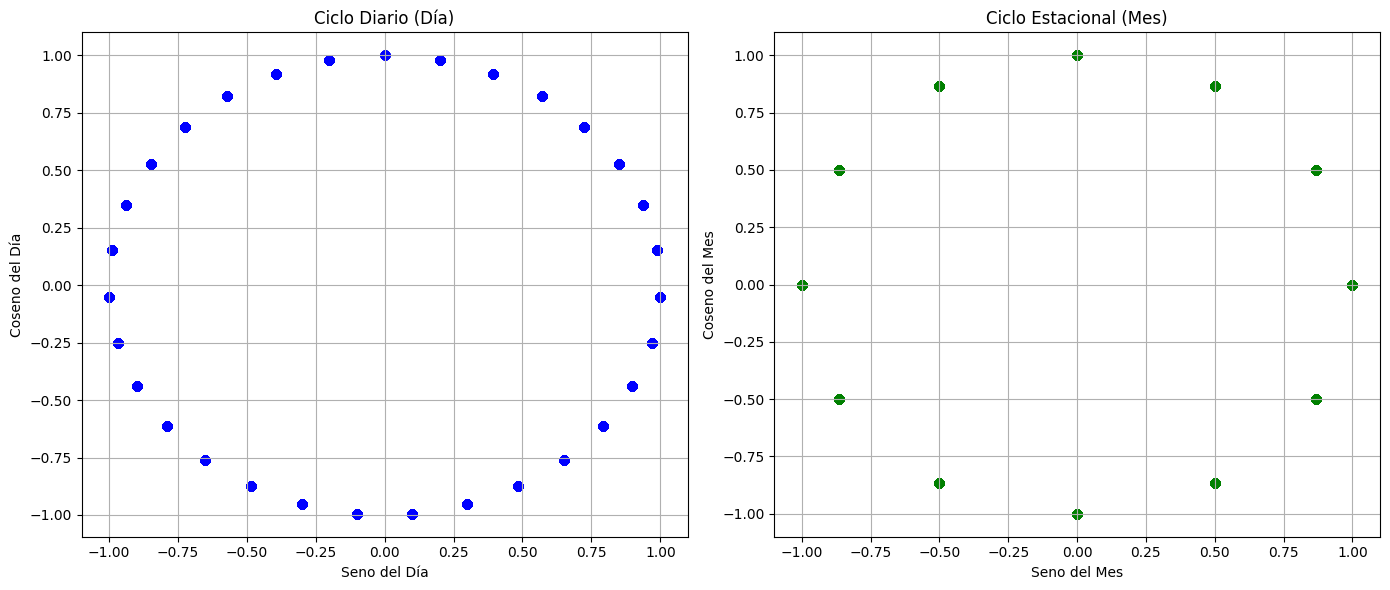

In [5]:
# Configurar tamaño de las figuras
plt.figure(figsize=(14, 6))

# Gráfica para los días
plt.subplot(1, 2, 1)  # Gráfico plano
plt.scatter(dataset_energia['dia_sin'], dataset_energia['dia_cos'], alpha=0.7, color='blue')
plt.title("Ciclo Diario (Día)")
plt.xlabel("Seno del Día")
plt.ylabel("Coseno del Día")
plt.grid(True)

# Gráfica para los meses
plt.subplot(1, 2, 2)  # Gráfico plano
plt.scatter(dataset_energia['mes_sin'], dataset_energia['mes_cos'], alpha=0.7, color='green')
plt.title("Ciclo Estacional (Mes)")
plt.xlabel("Seno del Mes")
plt.ylabel("Coseno del Mes")
plt.grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [6]:
# Se crea una columna de fecha numerica con la finalidad de que el modelo pueda detectar la secuencialidad de las fechas
dataset_energia['Fecha'] = pd.to_datetime(dataset_energia["Fecha"]).astype('int64') // 10**9 # En segundos

In [7]:
# Debido a los cambios drasticos de demanda se crea una columna siendo la diferencia de la demanda del día menos la del día anterior, esto ayuda a mejorar los cambios drasticos en la demanda
dataset_energia['demand_diff'] = dataset_energia['Demanda Energia SIN kWh'].diff().fillna(0)


In [8]:
# Seleccionar y normalizar datos
cols = ['Demanda Energia SIN kWh','Población','Temp_BOGOTA','Temp_ANTIOQUIA',
       'Temp_VALLE DEL CAUCA','Temp_ATLANTICO','Temp_BOLIVAR','Temp_CUNDINAMARCA',
       'Temp_NORTE DE SANTANDER','Temp_SANTANDER','Temp_CESAR','Temp_META','Fecha',
       'dia_sin','dia_cos','mes_sin','mes_cos','ano','demand_diff']
data = dataset_energia[cols]

In [9]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=cols)

In [10]:
# Dividir en entrenamiento y prueba
train_size = int(len(data_scaled) * 0.7)
train_data = data_scaled.iloc[:train_size]
test_data = data_scaled.iloc[train_size:]

In [11]:
# Crear secuencias para LSTM
def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].drop(target_col, axis=1).values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

SEQ_LENGTH = 7
X_train, y_train = create_sequences(train_data, target_col='Demanda Energia SIN kWh', seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, target_col='Demanda Energia SIN kWh', seq_length=SEQ_LENGTH)

In [12]:
# Redimensionar para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (4338, 7, 18), y_train.shape: (4338,)
X_test.shape: (1856, 7, 18), y_test.shape: (1856,)


In [13]:
# Seleccion de parametro iniciales
lstm_units = 256*2
batch_size = 32
epochs = 100
seq_length = 7
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)

In [14]:
# Crear modelo basico LSTM
model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    LSTM(int(lstm_units / 2), return_sequences=True),
    Dense(1)
])

c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])
# Usar Early Stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida: {loss}, MAE: {mae}")

# Generar predicciones en el conjunto de prueba
predicciones = model.predict(X_test)

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0264 - mae: 0.1813 - val_loss: 0.0541 - val_mae: 0.3055
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0109 - mae: 0.1215 - val_loss: 0.0420 - val_mae: 0.2649
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0104 - mae: 0.1198 - val_loss: 0.0516 - val_mae: 0.2984
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0109 - mae: 0.1227 - val_loss: 0.0511 - val_mae: 0.2968
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0106 - mae: 0.1211 - val_loss: 0.0563 - val_mae: 0.3134
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0106 - mae: 0.1211 - val_loss: 0.0501 - val_mae: 0.2930
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0108 - mae: 0.1220 - val_loss: 0.0486 - val_mae: 0.2884
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0102 - mae: 0.1179 - val_loss: 0.0563 - val_mae: 0.3136
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━

C:\Users\andre\AppData\Local\Temp\ipykernel_63772\2383604286.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


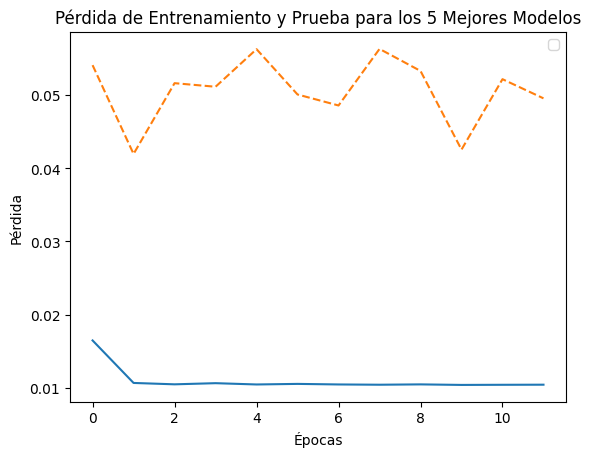

In [16]:
# Graficar pérdida de entrenamiento y prueba
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Pérdida de Entrenamiento y Prueba para los 5 Mejores Modelos')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [17]:
# Se agrega los parametros de drop rate y regularización para evitar el overfitting
lstm_units = 256*2
batch_size = 32
epochs = 100
seq_length = 7
optimizer = Adam(learning_rate=0.0005)
dropout_rate = 0.1
regu = 0.001
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)

In [18]:
# Crear modelo con regularización y dropout
model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2]), kernel_regularizer=l2(regu)),
    Dropout(dropout_rate),
    LSTM(int(lstm_units / 2), return_sequences=False, kernel_regularizer=l2(regu)),
    Dropout(dropout_rate),
    Dense(1)
])

In [19]:
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])
# Usar Early Stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida: {loss}, MAE: {mae}")

# Generar predicciones en el conjunto de prueba
predicciones = model.predict(X_test)

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.4430 - mae: 0.1154 - val_loss: 0.0670 - val_mae: 0.0844
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0487 - mae: 0.0717 - val_loss: 0.0226 - val_mae: 0.0823
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0182 - mae: 0.0721 - val_loss: 0.0133 - val_mae: 0.0988
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0102 - mae: 0.0726 - val_loss: 0.0095 - val_mae: 0.0970
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0070 - mae: 0.0702 - val_loss: 0.0071 - val_mae: 0.0836
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0058 - mae: 0.0720 - val_loss: 0.0064 - val_mae: 0.0840
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0052 - mae: 0.0710 - val_loss: 0.0069 - val_mae: 0.0965
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0049 - mae: 0.0710 - val_loss: 0.0056 - val_mae: 0.0827
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━

C:\Users\andre\AppData\Local\Temp\ipykernel_63772\97603538.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


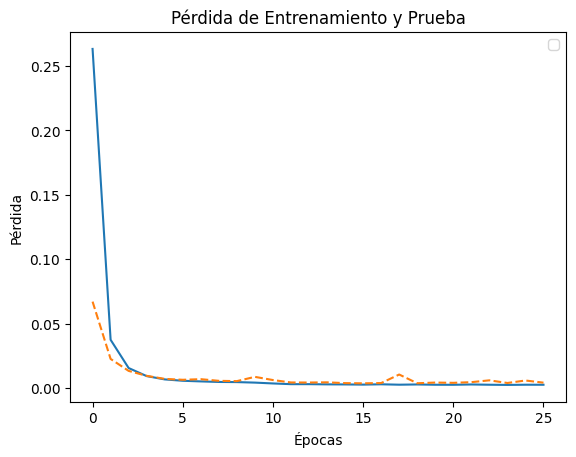

In [20]:
# Graficar pérdida de entrenamiento y prueba
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Pérdida de Entrenamiento y Prueba')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [21]:
# Desnormalizar los valores reales y predichos
def desnormalizar(scaler, datos_normalizados, target_col, columnas):
    """
    Desnormaliza un conjunto de datos a partir del scaler utilizado y las columnas originales.
    
    Args:
        scaler: Objeto MinMaxScaler usado para normalizar los datos.
        datos_normalizados: Datos normalizados (array).
        target_col: Nombre de la columna objetivo.
        columnas: Lista de nombres de las columnas originales.
    
    Returns:
        Serie con los valores desnormalizados de la columna objetivo.
    """
    # Crear DataFrame temporal con dimensiones correctas
    temp_df = pd.DataFrame(np.zeros((len(datos_normalizados), len(columnas))), columns=columnas)
    temp_df[target_col] = datos_normalizados
    
    # Transformar inversamente los datos
    desnormalizados = scaler.inverse_transform(temp_df)
    
    # Extraer solo la columna objetivo
    return desnormalizados[:, columnas.index(target_col)]

columnas_originales = cols  # Las columnas originales utilizadas en el scaler
valores_reales = desnormalizar(scaler, y_test, target_col='Demanda Energia SIN kWh', columnas=columnas_originales)
valores_predichos = desnormalizar(scaler, predicciones.flatten(), target_col='Demanda Energia SIN kWh', columnas=columnas_originales)

print("Estadísticas de los valores reales desnormalizados:")
print(pd.Series(valores_reales).describe())

print("Estadísticas de las predicciones desnormalizadas:")
print(pd.Series(valores_predichos).describe())

Estadísticas de los valores reales desnormalizados:
count    1.856000e+03
mean     2.040868e+08
std      1.592950e+07
min      1.471334e+08
25%      1.940749e+08
50%      2.053445e+08
75%      2.155133e+08
max      2.408332e+08
dtype: float64
Estadísticas de las predicciones desnormalizadas:
count    1.856000e+03
mean     2.026344e+08
std      1.035417e+07
min      1.671531e+08
25%      1.960261e+08
50%      2.035192e+08
75%      2.102022e+08
max      2.262211e+08
dtype: float64


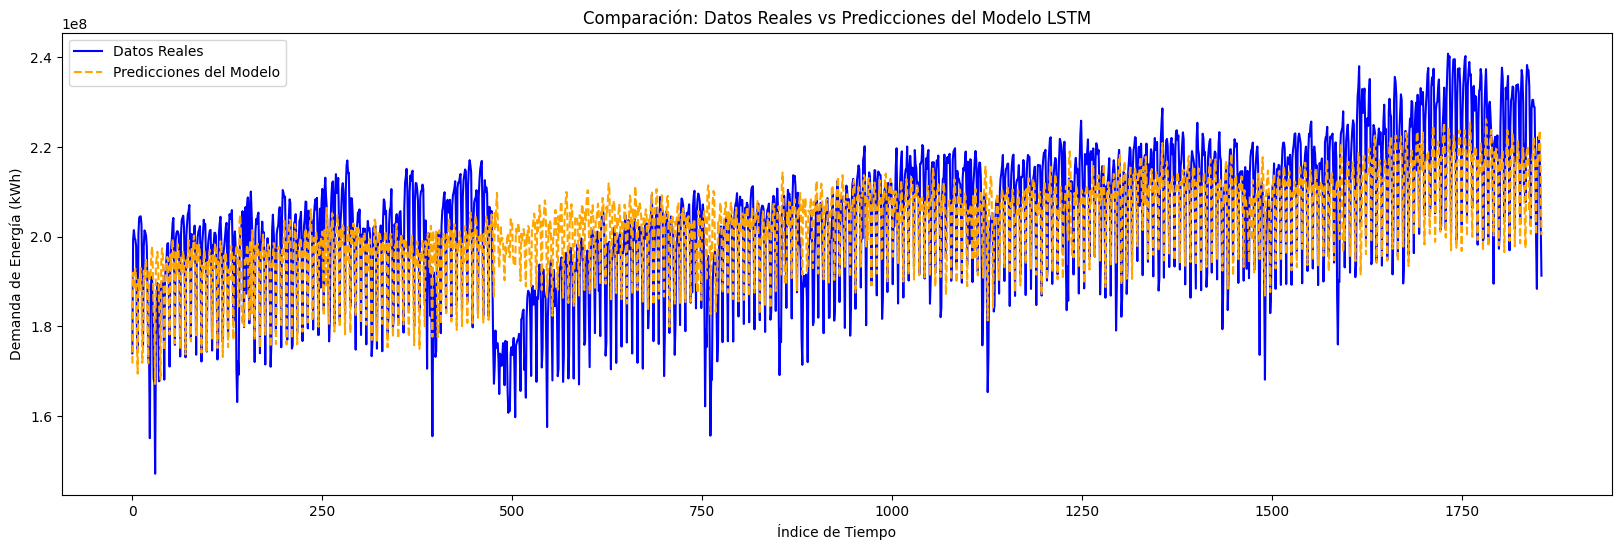

In [22]:
# Graficar datos reales vs predicciones
plt.figure(figsize=(20, 6))

plt.plot(valores_reales, label='Datos Reales', color='blue')
plt.plot(valores_predichos, label='Predicciones del Modelo', color='orange', linestyle='--')
plt.title('Comparación: Datos Reales vs Predicciones del Modelo LSTM')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.show()

## Busqueda de Hiperparametros

In [22]:
# Búsqueda manual de hiperparámetros
param_grid = {
    'lstm_units': [256, 256*2],
    'dropout_rate': [0.05, 0.1, 0.2],
    'batch_size': [16, 32],
    'epochs': [100],
    'seq_length': [1, 7, 14],
    'regu':[0.0001, 0.001, 0.01],
    'learning_rate':[0.0001, 0.0005]
}
# Lista para almacenar resultados
results = []

In [23]:
# Bucle para probar combinaciones de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando combinación: {params}")
    X_train, y_train = create_sequences(train_data, target_col='Demanda Energia SIN kWh', seq_length=params['seq_length'])
    X_test, y_test = create_sequences(test_data, target_col='Demanda Energia SIN kWh', seq_length=params['seq_length'])
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    # Crear modelo con los parámetros actuales
    model = Sequential([
    LSTM(params['lstm_units'], return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2]), kernel_regularizer=l2(regu)),
    Dropout(dropout_rate),
    LSTM(int(params['lstm_units'] / 2), return_sequences=False, kernel_regularizer=l2(regu)),
    Dropout(dropout_rate),
    Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=Huber(delta=1.0), metrics=['mae'])
    
    # Usar Early Stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenar el modelo
    history = model.fit(X_train, y_train,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=0)
                        
    # Evaluar en el conjunto de prueba
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    results.append({**params, 'loss': loss, 'mae': mae, 'history': history.history})

Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 256, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.0001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.001, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 1}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 7}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Probando combinación: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'lstm_units': 512, 'regu': 0.01, 'seq_length': 14}


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Ordenar resultados por pérdida y guardar en un archivo
results = sorted(results, key=lambda x: x['loss'])
pd.DataFrame(results).to_csv("resultados_modelos.csv", index=False)
print("Resultados guardados en 'resultados_modelos.csv'.")

Resultados guardados en 'resultados_modelos.csv'.


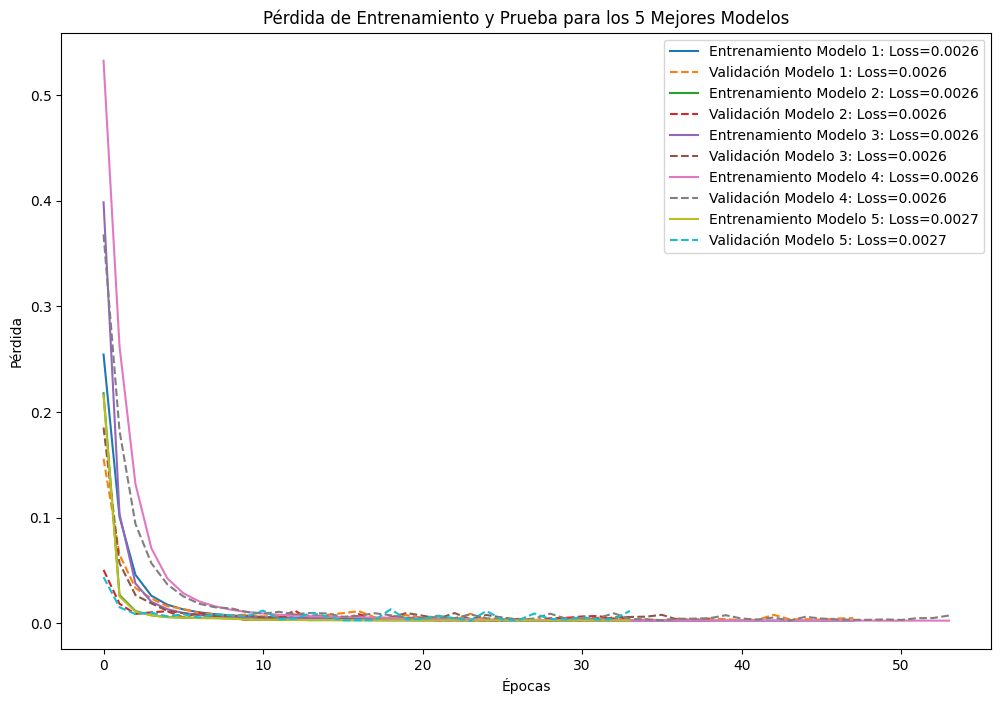

In [25]:
# Graficar el Top 5 (pérdida de entrenamiento y prueba)
top_5_results = results[:5]
plt.figure(figsize=(12, 8))
for i, result in enumerate(top_5_results):
    plt.plot(result['history']['loss'], label=f"Entrenamiento Modelo {i+1}: Loss={result['loss']:.4f}")
    plt.plot(result['history']['val_loss'], linestyle='--', label=f"Validación Modelo {i+1}: Loss={result['loss']:.4f}")
plt.title('Pérdida de Entrenamiento y Prueba para los 5 Mejores Modelos')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


## Analsis de resultados modelo final

In [23]:
parameters = pd.read_csv("resultados_modelos.csv",nrows=1)

batch_size = int(parameters['batch_size'])
dropout_rate = int(parameters['dropout_rate'])
epochs = int(parameters['epochs'])
learning_rate = float(parameters['learning_rate'])
lstm_units = int(parameters['lstm_units'])
regu = float(parameters['regu'])
seq_length = int(parameters['seq_length'])


C:\Users\andre\AppData\Local\Temp\ipykernel_63772\364467341.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  batch_size = int(parameters['batch_size'])
C:\Users\andre\AppData\Local\Temp\ipykernel_63772\364467341.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  dropout_rate = int(parameters['dropout_rate'])
C:\Users\andre\AppData\Local\Temp\ipykernel_63772\364467341.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  epochs = int(parameters['epochs'])
C:\Users\andre\AppData\Local\Temp\ipykernel_63772\364467341.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  learning_rate = float(parameters['learning_

In [24]:
X_train, y_train = create_sequences(train_data, target_col='Demanda Energia SIN kWh', seq_length=seq_length)
X_test, y_test = create_sequences(test_data, target_col='Demanda Energia SIN kWh', seq_length=seq_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Crear modelo con los parámetros actuales
model = Sequential([
LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, X_train.shape[2]), kernel_regularizer=l2(regu)),
Dropout(dropout_rate),
LSTM(int(lstm_units / 2), return_sequences=False, kernel_regularizer=l2(regu)),
Dropout(dropout_rate),
Dense(1)
])
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(delta=1.0), metrics=['mae'])

# Usar Early Stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=0)
                    
# Evaluar en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test, verbose=0)

c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\andre\AppData\Local\Temp\ipykernel_63772\2845901790.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


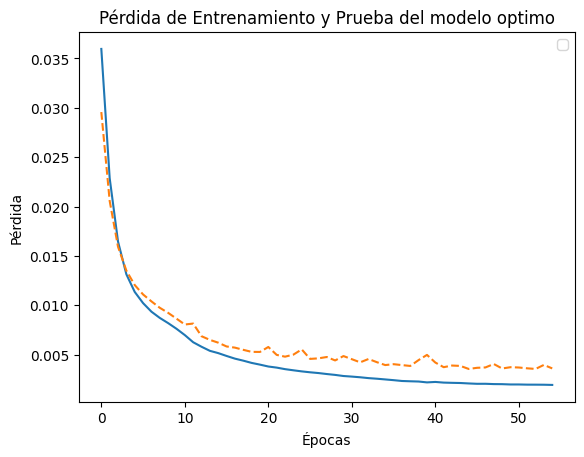

In [25]:
# Graficar pérdida de entrenamiento y prueba
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Pérdida de Entrenamiento y Prueba del modelo optimo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [26]:
# Generar predicciones en el conjunto de prueba
predicciones = model.predict(X_test)

# Desnormalizar los valores reales y predichos
def desnormalizar(scaler, datos_normalizados, target_col, columnas):
    """
    Desnormaliza un conjunto de datos a partir del scaler utilizado y las columnas originales.
    
    Args:
        scaler: Objeto MinMaxScaler usado para normalizar los datos.
        datos_normalizados: Datos normalizados (array).
        target_col: Nombre de la columna objetivo.
        columnas: Lista de nombres de las columnas originales.
    
    Returns:
        Serie con los valores desnormalizados de la columna objetivo.
    """
    # Crear DataFrame temporal con dimensiones correctas
    temp_df = pd.DataFrame(np.zeros((len(datos_normalizados), len(columnas))), columns=columnas)
    temp_df[target_col] = datos_normalizados
    
    # Transformar inversamente los datos
    desnormalizados = scaler.inverse_transform(temp_df)
    
    # Extraer solo la columna objetivo
    return desnormalizados[:, columnas.index(target_col)]

columnas_originales = cols  # Las columnas originales utilizadas en el scaler
valores_reales = desnormalizar(scaler, y_test, target_col='Demanda Energia SIN kWh', columnas=columnas_originales)
valores_predichos = desnormalizar(scaler, predicciones.flatten(), target_col='Demanda Energia SIN kWh', columnas=columnas_originales)

print("Estadísticas de los valores reales desnormalizados:")
print(pd.Series(valores_reales).describe())

print("Estadísticas de las predicciones desnormalizadas:")
print(pd.Series(valores_predichos).describe())

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Estadísticas de los valores reales desnormalizados:
count    1.856000e+03
mean     2.040868e+08
std      1.592950e+07
min      1.471334e+08
25%      1.940749e+08
50%      2.053445e+08
75%      2.155133e+08
max      2.408332e+08
dtype: float64
Estadísticas de las predicciones desnormalizadas:
count    1.856000e+03
mean     2.041717e+08
std      1.171739e+07
min      1.582353e+08
25%      1.975330e+08
50%      2.061693e+08
75%      2.122103e+08
max      2.332854e+08
dtype: float64


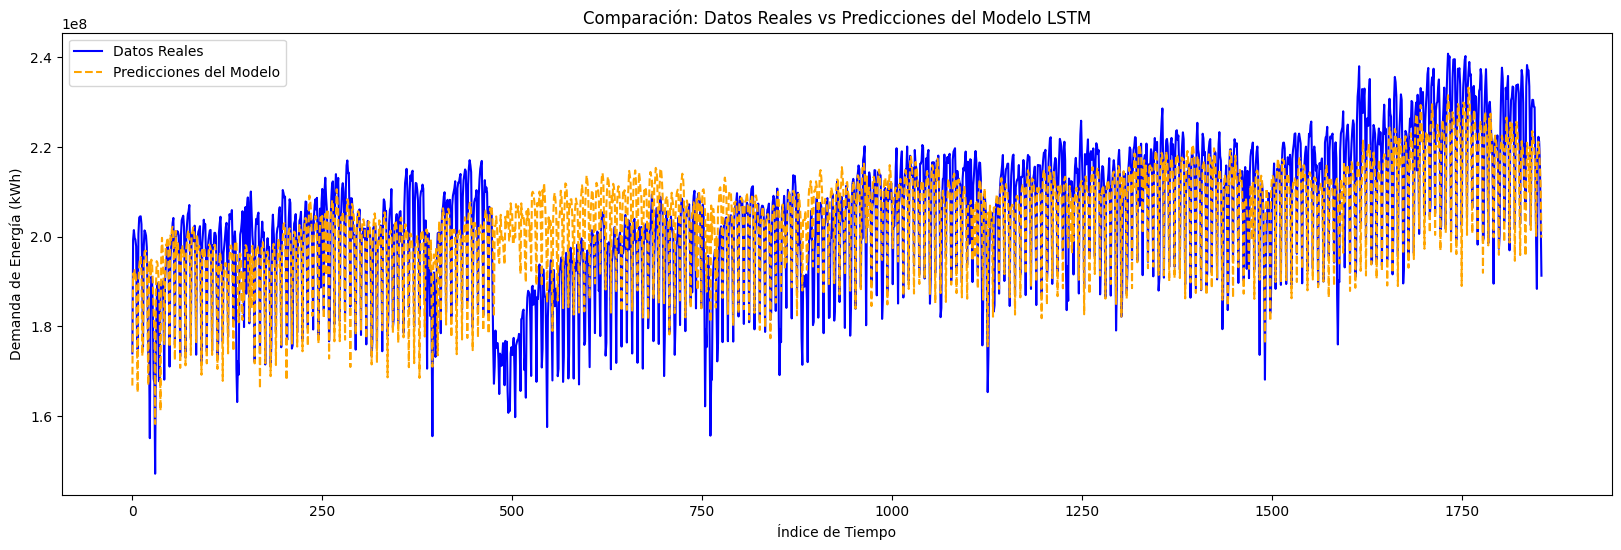

In [27]:
# Graficar datos reales vs predicciones
plt.figure(figsize=(20, 6))

plt.plot(valores_reales, label='Datos Reales', color='blue')
plt.plot(valores_predichos, label='Predicciones del Modelo', color='orange', linestyle='--')
plt.title('Comparación: Datos Reales vs Predicciones del Modelo LSTM')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.show()

In [28]:
# Claculo de metricas de error para el modelo LSTM
mae = mean_absolute_error(valores_reales, valores_predichos)
mse = mean_squared_error(valores_reales, valores_predichos)
rmse = np.sqrt(mse)
r2 = r2_score(valores_reales, valores_predichos)

# Cálculo de MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el MAPE entre los valores reales y predichos.
    Evita la división por cero reemplazando valores de `y_true` cercanos a cero.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Manejar divisiones por cero
    epsilon = np.finfo(float).eps
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100

mape = mean_absolute_percentage_error(valores_reales, valores_predichos)

# Almacenar las métricas en un diccionario
metricas = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
}

# Mostrar métricas en consola
print("Métricas de evaluación del modelo:")
for nombre, valor in metricas.items():
    print(f"{nombre}: {valor:.4f}")


Métricas de evaluación del modelo:
MAE: 7648310.7141
MSE: 103856544031919.7344
RMSE: 10191003.0925
R2: 0.5905
MAPE: 3.8721


In [29]:
# Guardando el modelo final
model.save("modelo_lstm_final.h5")